In [1]:
!pip install kaggle

In [2]:
#Upload your own kaggle account's json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"piyusrout","key":"71f444a7f1387e811778bef18826b18c"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d tongpython/cat-and-dog

 94% 205M/218M [00:09<00:00, 21.3MB/s]
100% 218M/218M [00:09<00:00, 24.7MB/s]


In [ ]:
!unzip cat-and-dog.zip

In [6]:
!rm cat-and-dog.zip

In [7]:
!pip install livelossplot

In [8]:
import numpy as np
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
%matplotlib inline

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D , MaxPool2D , Flatten , Dense , Activation , Dropout
from keras.optimizers import Adam , RMSprop
from keras.models import Sequential
from keras.callbacks import TensorBoard , ModelCheckpoint , EarlyStopping
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix

In [9]:
if not os.path.isdir("train/"):
  os.mkdir("train")
  shutil.move("training_set/training_set/cats" , "train/")
  shutil.move("training_set/training_set/dogs" , "train/")

if not os.path.isdir("test/"):
  os.mkdir("test")
  shutil.move("test_set/test_set/cats" , "test/")
  shutil.move("test_set/test_set/dogs" , "test/")

In [10]:
!rm -r training_set
!rm -r test_set

In [11]:
train_dir = "train"
train_cats = os.listdir("train/cats")
train_dogs = os.listdir("train/dogs")

print("There are " + str(len(train_cats)) + " cat samples.")
print("There are " + str(len(train_dogs)) + " dog samples.")

There are 4001 cat samples.
There are 4006 dog samples.


In [12]:
test_dir = "train"
test_cats = os.listdir("test/cats")
test_dogs = os.listdir("test/dogs")

print("There are " + str(len(test_cats)) + " cat samples.")
print("There are " + str(len(test_dogs)) + " dog samples.")

There are 1012 cat samples.
There are 1013 dog samples.


In [13]:
img_size = 220
batch_size = 64

datagen_train = ImageDataGenerator(shear_range=0.2,
                                   rescale=1./255.,
                                   horizontal_flip=True)
train_generator = datagen_train.flow_from_directory('train',
                                                    target_size=(img_size , img_size),
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    shuffle=True)

Found 8005 images belonging to 2 classes.


In [14]:
img_size = 220
batch_size = 64

datagen_test = ImageDataGenerator(shear_range=0.2,
                                   rescale=1./255.,
                                   horizontal_flip=True)
test_generator = datagen_test.flow_from_directory('test',
                                                    target_size=(img_size , img_size),
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    shuffle=False)

Found 2023 images belonging to 2 classes.


In [15]:
model = Sequential()

#Layer 1
model.add(Conv2D(32 , (3 , 3) , padding='same' , activation='relu' , input_shape = (img_size , img_size , 3)))
model.add(MaxPool2D(pool_size=(2 , 2)))
#model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(64 , (3 , 3) , padding='same' , activation='relu'))
model.add(MaxPool2D(pool_size=(2 , 2)))
#model.add(Dropout(0.25))

#Layer 3
model.add(Conv2D(128 , (3 , 3) , padding='same' , activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

#FC1
model.add(Dense(units=256 , activation='relu'))
model.add(Dropout(0.5))

#FC2
model.add(Dense(units=1 , activation='sigmoid'))

optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer , loss='binary_crossentropy' , metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0

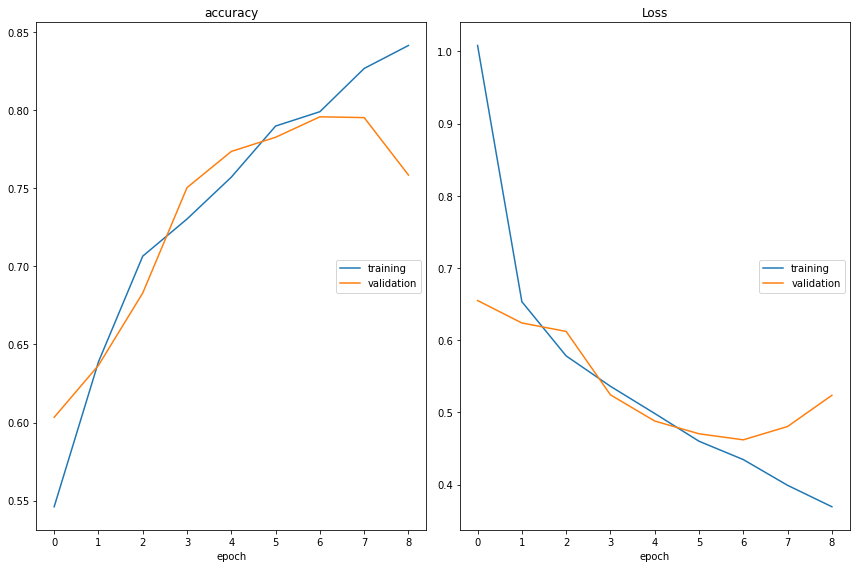

accuracy
	training         	 (min:    0.546, max:    0.842, cur:    0.842)
	validation       	 (min:    0.603, max:    0.796, cur:    0.759)
Loss
	training         	 (min:    0.369, max:    1.008, cur:    0.369)
	validation       	 (min:    0.462, max:    0.655, cur:    0.524)

Epoch 00009: val_accuracy did not improve from 0.79587
Epoch 00009: early stopping


In [17]:
epochs=50
steps_per_epoch=train_generator.n // train_generator.batch_size
validation_steps=test_generator.n // test_generator.batch_size
checkpoint = ModelCheckpoint('weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             save_best_only=True,
                             mode='max',
                             verbose=1)
earlystop = EarlyStopping(monitor='val_loss' , patience=2 , mode='min' , min_delta=0.0005 , verbose=1)

callbacks = [PlotLossesKeras() , earlystop , checkpoint]
history = model.fit(x=train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=test_generator,
          validation_steps=validation_steps,
          callbacks=callbacks)

In [18]:
!ls

kaggle.json  sample_data  test	train  weights.h5


In [19]:
model_json = model.to_json()

In [20]:
with open("model.json" , "w") as json_file:
  json_file.write(model_json)

In [21]:
!ls

kaggle.json  model.json  sample_data  test  train  weights.h5


In [30]:
files.download('model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
!kaggle competitions download -c dogs-vs-cats

 98% 532M/543M [00:09<00:00, 58.0MB/s]
100% 543M/543M [00:09<00:00, 62.7MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 75.8MB/s]
100% 270M/271M [00:06<00:00, 46.2MB/s]
100% 271M/271M [00:06<00:00, 41.4MB/s]


In [24]:
!rm -r train
!rm -r test

In [25]:
!ls

kaggle.json  sample_data	   test1.zip  weights.h5
model.json   sampleSubmission.csv  train.zip


In [ ]:
!unzip train.zip
!unzip test1.zip

In [27]:
!rm train.zip
!rm test1.zip
!rm sampleSubmission.csv

In [31]:
y_true = []
y_predict = []

for file in os.listdir("train"):
  if "cat" in file:
    y_true.append(0)
  else:
    y_true.append(1)

  img = cv2.imread(os.path.join("train" , file))
  img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
  img = cv2.resize(img , (220 , 220))
  res = model.predict(img[np.newaxis, :, :])
  if res >= 0.5:
    res = 1
  else:
    res = 0
  y_predict.append(res)

y_true = np.array(y_true)
y_predict = np.array(y_predict)  

In [32]:
cm = confusion_matrix(y_true=y_true , y_pred=y_predict)

In [33]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10557  1943]
 [ 3924  8576]]


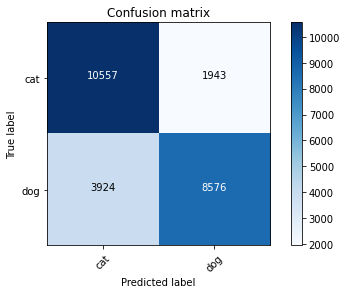

In [34]:
plot_confusion_matrix(cm=cm , classes=['cat' , 'dog'])

In [35]:
files.download('weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>